# Homework 9
###### by Mher Movsisyan
---

### Problem 1:  
Explain the similarities and differences between the SVM and perceptron algorithms. How do they perform classification? In what way do they differ?

Answer:  
Both are linear classifiers, both are supervised. However, SVM finds the maximum margin while a perceptron just minimizes the error and thus is satisfied with any good decision boundary.

### Problem 2:  
Recall that the dual function in the setting of the SVM training task (Slide "Solving the dual problem") can be written as 
$$ g(\alpha) \frac{1}{2}\alpha^TQ\alpha + \alpha^T1_N $$  
a) Write down the matrix Q using the vector of labels y and feature matrix X. Denote the element-wise product between two matrices (in case you want to use it) by ⊙ (also known as Hadamard
product or Schur product)

Answer:  
$$ -(y ⊙ y^T) ⊙ (xx^T) $$

b) Prove that we can search for a local maximizer of g to find its global maximum (don’t forget to
prove properties of Q that you decide to use in this task).

Answer:  
We can search for a local maximizer if `g` is concave. This is only the case when Q is NSD, it is NSD because it is -1 * the ⊙ product y, $ y^T $, and $ xx^T $

Consider training a standard hard-margin SVM on a linearly separable training set of N
samples. Let `s` denote the number of support vectors we would obtain if we would train on the entire
dataset. Furthermore, let `ε` denote the leave-one-out cross validation (LOOCV) misclassification rate.
Prove that the following relation holds:  
$$ \epsilon \leq \frac{s}{N} $$  

Answer:  
In hard-margin SVM, all points on or beyond the margin are support vectors. All points beyond the boundary line are misclassified, therefore all misclassified points must be support vectors. $ \frac{s}{N} $ is the fraction of points that are support vectors, and we will see the proof when we multiply both sides with N and get $ N_{misclassified} \leq s $ which is true under sentance one and two.


### Problem 4: Coding part

# Programming assignment: SVM

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_blobs

from cvxopt import matrix, solvers

## Your task

In this sheet we will implement a simple binary SVM classifier.
Your task is to complete the functions where required. 
You are only allowed to use built-in Python functions, as well as any `numpy` functions. No other libraries / imports are allowed.

To solve optimization tasks we will use **`CVXOPT`** http://cvxopt.org/ - a Python library for convex optimization. If you use `Anaconda`, you can install it using

    conda install cvxopt

## Generate and visualize the data

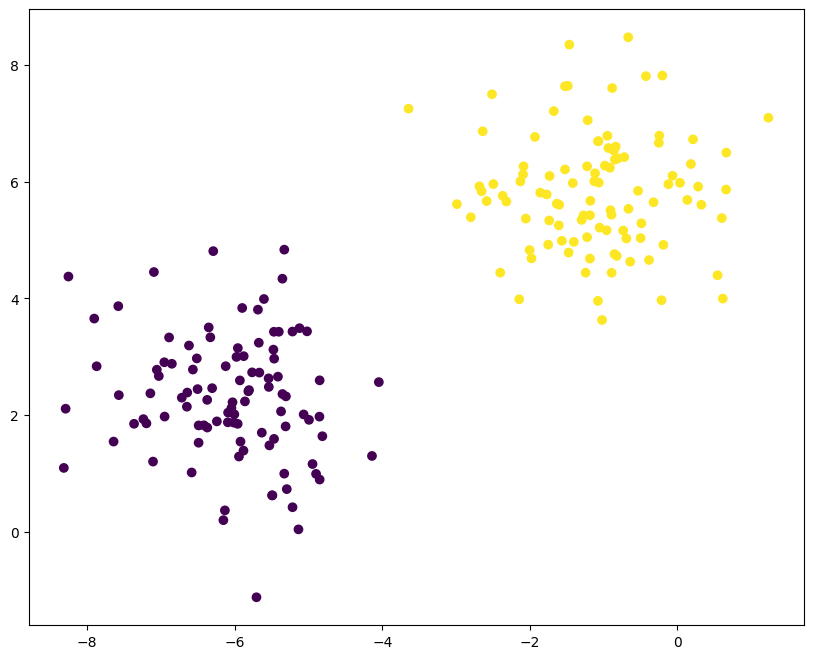

In [4]:
N = 200  # number of samples
D = 2  # number of dimensions
C = 2  # number of classes
seed = 1234  # for reproducible experiments

alpha_tol = 1e-4 # threshold for choosing support vectors

X, y = make_blobs(n_samples=N, n_features=D, centers=C, random_state=seed)
y[y == 0] = -1  # it is more convenient to have {-1, 1} as class labels (instead of {0, 1})
y = y.astype(np.float32) # changed to float32 for version compatibility
plt.figure(figsize=[10, 8])
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

## Task 1: Solving the SVM dual problem

Remember, that the SVM dual problem can be formulated as a Quadratic programming (QP) problem.
We will solve it using a QP solver from the `CVXOPT` library.

We use the following form of a QP problem:
$$
\text{minimize}_{\mathbf{x}}\quad
    \frac{1}{2}\mathbf{x}^T \mathbf{P} \mathbf{x} + \mathbf{q}^T \mathbf{x} \\
\text{subject to}\quad
    \mathbf{G}\mathbf{x} \le \mathbf{h}\text{ and }
    \mathbf{A}\mathbf{x} = \mathbf{b}\, .
$$

**Your task** is to formulate the SVM dual problems as a QP of this form and solve it using `CVXOPT`, i.e. specify the matrices $\mathbf{P}, \mathbf{G}, \mathbf{A}$ and vectors $\mathbf{q}, \mathbf{h}, \mathbf{b}$.

In [19]:
def solve_dual_svm(X, y):
    """Solve the dual formulation of the SVM problem.
    
    Parameters
    ----------
    X : array, shape [N, D]
        Input features.
    y : array, shape [N]
        Binary class labels (in {-1, 1} format).
    
    Returns
    -------
    alphas : array, shape [N]
        Solution of the dual problem.
    """
    ### TODO: Your code below ###
    N, D = X.shape
    Q = np.outer(y, y) * np.dot(X, X.T)
    # These variables have to be of type cvxopt.matrix
    P = matrix(Q)
    q = matrix(-1 * np.ones(N))
    G = matrix(-1 * np.eye(N))
    h = matrix(np.zeros(N))
    A = matrix(y.astype(np.double), (1, N), tc="d")
    b = matrix(0.0)
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(solution['x'])
    return alphas.reshape(-1)

## Task 2: Recovering the weights and the bias

In [23]:
def compute_weights_and_bias(alpha, X, y):
    """Recover the weights w and the bias b using the dual solution alpha.
    
    Parameters
    ----------
    alpha : array, shape [N]
        Solution of the dual problem.
    X : array, shape [N, D]
        Input features.
    y : array, shape [N]
        Binary class labels (in {-1, 1} format).
    
    Returns
    -------
    w : array, shape [D]
        Weight vector.
    b : float
        Bias term.
    """
    ### TODO: Your code below ###
    w = np.sum(alpha[:, np.newaxis] * y[:, np.newaxis] * X, axis=0)

    sv = (alpha > 1e-7)
    sv_idxs = np.where(sv)[0]
    sv_idx = sv_idxs[0]
    sv_y = y[sv_idx]
    sv_x = X[sv_idx]
    b = sv_y - np.dot(w, sv_x)
    return w, b

## Visualize the result (nothing to do here)

In [24]:
def plot_data_with_hyperplane_and_support_vectors(X, y, alpha, w, b):
    """Plot the data as a scatter plot together with the separating hyperplane.
    
    Parameters
    ----------
    X : array, shape [N, D]
        Input features.
    y : array, shape [N]
        Binary class labels (in {-1, 1} format).
    alpha : array, shape [N]
        Solution of the dual problem.
    w : array, shape [D]
        Weight vector.
    b : float
        Bias term.
    """
    plt.figure(figsize=[10, 8])
    # Plot the hyperplane
    slope = -w[0] / w[1]
    intercept = -b / w[1]
    x = np.linspace(X[:, 0].min(), X[:, 0].max())
    plt.plot(x, x * slope + intercept, 'k-', label='decision boundary')
    plt.plot(x, x * slope + intercept - 1/w[1], 'k--')
    plt.plot(x, x * slope + intercept + 1/w[1], 'k--')
    # Plot all the datapoints
    plt.scatter(X[:, 0], X[:, 1], c=y)
    # Mark the support vectors
    support_vecs = (alpha > alpha_tol)
    plt.scatter(X[support_vecs, 0], X[support_vecs, 1], c=y[support_vecs], s=250, marker='*', label='support vectors')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend(loc='upper left')

The reference solution is

    w = array([0.73935606 0.41780426])
    
    b = 0.919937145

Indices of the support vectors are
    
    [ 78 134 158]

In [25]:
alpha = solve_dual_svm(X, y)
w, b = compute_weights_and_bias(alpha, X, y)
print("w =", w)
print("b =", b)
print("support vectors:", np.arange(len(alpha))[alpha > alpha_tol])

w = [0.73935606 0.41780426]
b = 0.9199371711281716
support vectors: [ 78 134 158]


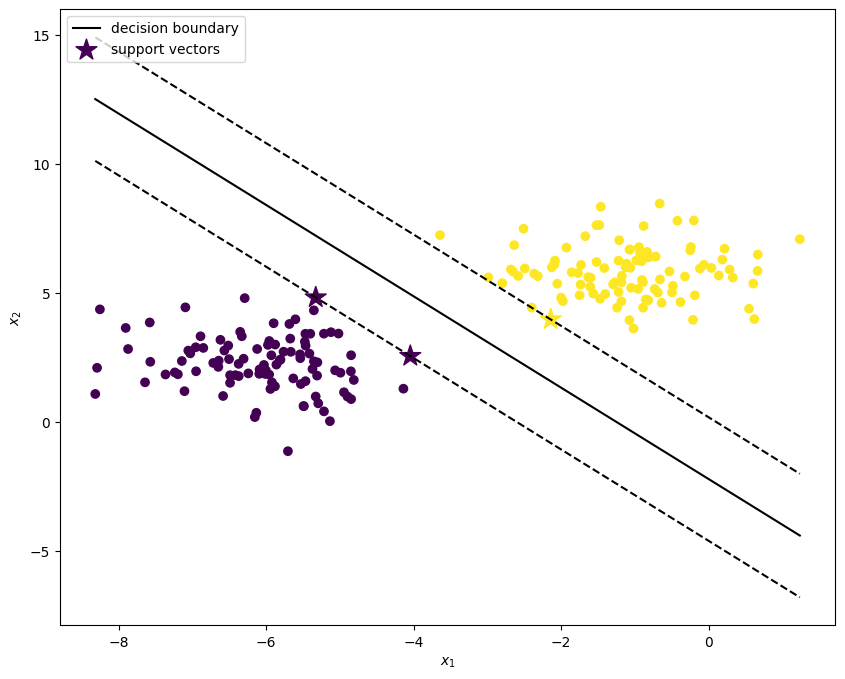

In [26]:
plot_data_with_hyperplane_and_support_vectors(X, y, alpha, w, b)
plt.show()

### Problem 5:  
Show that for $ N \in \mathbb{N} $ and $ a_i \geq 0 $ for $ i = 0, \dots, N $ the following function k is a valid kernel.
$$ k(x_1, x_2) = \frac{1}{1 - x_1x_2}, \text{ with } x_1, x_2 \in (0, 1) $$

Answer:  
For it to be valid, it needs to be symmetric PSD. It can be negative only when $ x_1x_2 > 1 $. Since our xs are never 1, this is a valid kernel

I just realized that I copied the wrong part, (p6 instead of p5), here is the actual one:

$$ k(x_1, x_2) = \sum_{i=1}^{N}a_i(x_1^Tx_2)^i + a_0, \text{ with } x_1, x_2 \in \mathbb{R}^d $$

Answer:  
$ x_1^Tx_2 $ is a valid kernel, the power to `i` of a valid kernel is a valid kernel, the product of that with a non-negative constant is a valid kernel, the sum of those products is a valid kernel, and finally adding a non-negative constant doesn't affect it's validity.

### Problem 6:  
Find the feature transformation ϕ(x) corresponding to the kernel  
$$ k(x_1, x_2) = \frac{1}{1 - x_1x_2}, \text{ with } x_1, x_2 \in (0, 1) $$
*Hint: Consider an infinite-dimensional feature space and infinite series.*

From the hint, I guess that e use the infinite series $ 1 + x_1x_2 + (x_1x_2)^2 + (x_1x_2)^3 \dots = \frac{1}{1-x_1x_2} $. The transformation is just $ \phi(x) = (1, x, x^2, x^3, \dots) $